<a href="https://colab.research.google.com/github/PravyPrerana-1610/Codes/blob/main/EE_Sascha_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# source target entanglement

In [3]:
pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.8/31.8 MB 2.0 MB/s eta 0:00:00


In [8]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import networkx as nx


# Avoid LaTeX calls
plt.rcParams['text.usetex'] = False
plt.rcParams['figure.figsize'] = (9, 5)

In [9]:

def flip_flop_shift(psi, flip_map):
    # psi: input quantum state
    # flip_map: instead of applying a flip-flop matrix we directly perform the
    #           action on the state. Thus we need a dictionary telling us which
    #           states are mapped to which

    new_psi = np.zeros_like(psi)

    for idx, target_idx in flip_map.items():
        if target_idx is not None:
            new_psi[target_idx] = psi[idx]
    return new_psi


In [12]:
def apply_grover_coin_vectorized(psi, G1, edge_index):
    """
    Applies Grover coin to each node's outgoing edge subspace.

    Parameters:
    - psi: numpy array of shape (num_edges,), complex vector over directed edges
    - G1: networkx.DiGraph
    - edge_index: dict mapping (u, v) edges to their index in psi

    Returns:
    - new_psi: numpy array, same shape as psi, after Grover coin applied
    """
    new_psi = psi.copy()

    for node in G1.nodes:
        # Get outgoing edges from node
        out_edges = list(G1.out_edges(node))
        indices = [edge_index[e] for e in out_edges]

        if len(indices) == 0:
            continue  # skip isolated node

        subvec = psi[indices]
        d = len(subvec)
        avg = np.sum(subvec) / d
        new_psi[indices] = 2 * avg - subvec  # Grover reflection
    return new_psi

def apply_tumble_coin_vectorized(psi, G1, edge_index):
    """
    Applies Grover coin to each node's outgoing edge subspace.

    Parameters:
    - psi: numpy array of shape (num_edges,), complex vector over directed edges
    - G1: networkx.DiGraph
    - edge_index: dict mapping (u, v) edges to their index in psi

    Returns:
    - new_psi: numpy array, same shape as psi, after Grover coin applied
    """
    new_psi = psi.copy()

    for node in G1.nodes:
        # Get outgoing edges from node
        out_edges = list(G1.out_edges(node))
        indices = [edge_index[e] for e in out_edges]

        if len(indices) == 0:
            continue  # skip isolated node

        new_psi[indices] = np.random.permutation(psi[indices])

    return new_psi


In [13]:
def node_occupations(state, degrees):
    """
    Computes the occupation probability of each node from a coined quantum walk state vector.

    Parameters
    ----------
    state : np.ndarray
        Complex state vector of size sum(degrees).
        Ordered as [ (node 0, coin 0..deg0-1), (node 1, coin 0..deg1-1), ... ]
    degrees : np.ndarray or list
        Degree of each node.

    Returns
    -------
    occ : np.ndarray
        Occupation probabilities for each node.
    """
    # Ensure we have a NumPy array
    state = np.asarray(state)
    degrees = np.asarray(degrees)

    occ = np.empty(len(degrees), dtype=np.float64)

    start = 0
    for i, deg in enumerate(degrees):
        # slice amplitudes for this node and sum squared magnitudes
        node_slice = state[start:start+deg]
        occ[i] = np.sum(np.abs(node_slice)**2)
        start += deg

    return occ

In [14]:
def evolve_new(ini_state, GG,edge_index, flip_map, degrees, t_max, dec):

    state = ini_state.copy()

    occupation = np.zeros((t_max,len(GG.nodes)))

    EE = np.zeros(t_max)

    for t in range(t_max):

        updated_state = np.zeros_like(state)

        if dec[t]:

            updated_state = apply_tumble_coin_vectorized(state, GG, edge_index)

        else:
            updated_state = flip_flop_shift(apply_grover_coin_vectorized(state, GG, edge_index), flip_map)


        state = updated_state

        occupation[t] = node_occupations(updated_state,degrees[:,1])

        state_matrix = state_to_matrix(state,GG,edges)

        _, S, _ = LA.svd(state_to_matrix(state,GG,edges))
        S /= np.linalg.norm(S)

        EE[t] = von_neumann_entropy(S**2)

    return occupation, state, EE/np.log2(len(GG.nodes))


In [15]:
def von_neumann_entropy(vals, tol=1e-12):
    # eigenvalues might be slightly negative due to numerical errors -> clip
    vals = vals[vals > tol]
    return -np.sum(vals * np.log2(vals))

def state_to_matrix(psi, GG, edges):

    dim = len(GG.nodes)

    state_matrix = np.zeros((dim,dim),dtype = 'complex')

    for j in np.where(psi != 0)[0]:
        state_matrix[edges[j]] = psi[j]

    return state_matrix


In [16]:

G = nx.complete_graph(8)
GG = nx.DiGraph(G)
#nx.draw(GG,with_labels = 'True')

In [17]:
# set up the Hilbert space structure ..............................................................
# dimension of Hilbert space
dim = len(GG.edges)

# list that contains basis states
edges = list(GG.edges)

# degrees of nodes = dimensions of subvecor spaces
degrees = np.array(GG.out_degree)

# dictionary identifies edge index
edge_index = {edge: idx for idx, edge in enumerate(edges)}

# construct map for flip flop operator
flip_map = {}
for idx, (u, v) in enumerate(edges):
    if (v, u) in edge_index:
        flip_map[idx] = edge_index[(v, u)]
    else:
        # If (v,u) not in graph, you can decide to skip, reflect, or raise error
        flip_map[idx] = None  # or idx to stay in place

In [18]:
t_max = 10**3
p_t = 0

N_runs = 1

dec = np.random.rand(N_runs, t_max) < p_t


ini_state = np.zeros(dim, dtype='complex')
ini_state[0] = 1

100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


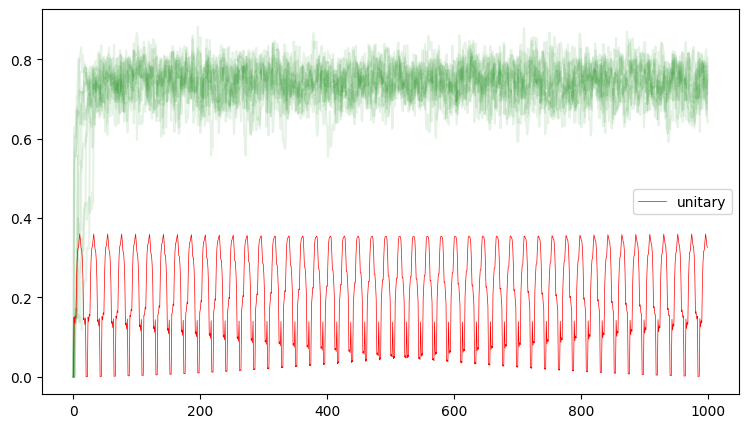

In [19]:
result1 = Parallel(n_jobs=-1)(delayed(evolve_new)(ini_state, GG, edge_index, flip_map, degrees, t_max, dec[i]) \
                             for i in tqdm(range(N_runs)))

ent = np.array([item[-1] for item in result1])

reference = ent.T
#%%
p_t = 0.3

N_runs = 10

dec = np.random.rand(N_runs, t_max) < p_t

result = Parallel(n_jobs=-1)(delayed(evolve_new)(ini_state, GG, edge_index, flip_map, degrees, t_max, dec[i]) \
                             for i in tqdm(range(N_runs)))

#%%
ent = np.array([item[-1] for item in result])

plt.plot(ent.T,color = 'g',alpha = 0.1);
plt.plot(reference,color='r',lw = .5,label = 'unitary')

plt.legend()